# Patient Stratification

In [56]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from clusteval import clusteval
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import os
import sys
import logging
import io

from venny4py.venny4py import *
from venn import venn


In [19]:
nblog = open("rf_prediction.log", "w")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [13]:
os.environ['PYTHONUTF8'] = '1'

In [47]:
dir ='Lisbon+Coimbra'
df = pd.read_csv('../data/'+dir+'/data.csv', encoding='utf-8')
patient_code = df['Code']
patient_group = df['Group']
df.drop(columns = ['Code','Group'], inplace = True) # drop unwanted columns
df

,IBP7,FETUA,TTHY,A2GL,FBLN2,FINC,NBL1,PLTP,CH3L1,C1QC,...,CAHD1,LV223,LYSC,LAMB2,IGD,SEM7A,G6PI,IBP4,CNTN2,CEMIP
0,0.000329,0.000852,0.02010,0.000549,0.000497,0.00268,0.000045,0.001050,0.002210,0.000509,...,0.000151,0.000009,0.000015,0.000214,0.000052,0.000572,0.000109,0.000031,0.000852,0.000035
1,0.000264,0.000662,0.01560,0.000277,0.000500,0.00298,0.000050,0.001210,0.000824,0.000587,...,0.000161,0.000043,0.000032,0.000272,0.000041,0.000466,0.000043,0.000005,0.000804,0.000030
2,0.000197,0.001740,0.01190,0.000438,0.000234,0.00158,0.000029,0.000962,0.000638,0.000330,...,0.000131,0.000016,0.000043,0.000099,0.000091,0.000413,0.000011,0.000006,0.000560,0.000048
3,0.000267,0.001040,0.01970,0.000666,0.000438,0.00166,0.000026,0.000792,0.001120,0.000304,...,0.000112,0.000005,0.000026,0.000174,0.000039,0.000535,0.000015,0.000004,0.000469,0.000024
4,0.000200,0.001080,0.01310,0.000693,0.000075,0.00204,0.000035,0.001300,0.001600,0.000443,...,0.000102,0.000008,0.000018,0.000115,0.000066,0.000382,0.000007,0.000006,0.000692,0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.000082,0.000893,0.00917,0.000406,0.000499,0.00199,0.000026,0.001050,0.000782,0.000290,...,0.000114,0.000028,0.000067,0.000097,0.000137,0.000355,0.000076,0.000010,0.000478,0.000047
124,0.000107,0.000597,0.00671,0.000370,0.000324,0.00201,0.000004,0.000735,0.000988,0.000236,...,0.000166,0.000016,0.000393,0.000201,0.000021,0.000398,0.000012,0.000007,0.000317,0.000043
125,0.000103,0.000620,0.00846,0.000393,0.000318,0.00256,0.000027,0.001460,0.000843,0.000169,...,0.000114,0.000027,0.000045,0.000236,0.000078,0.000516,0.000016,0.000003,0.000556,0.000025
126,0.000119,0.000317,0.01320,0.000387,0.000056,0.00377,0.000001,0.000738,0.002090,0.000228,...,0.000094,0.000019,0.000445,0.000183,0.000050,0.000513,0.000004,0.000002,0.001320,0.000024


In [48]:
folder_path = '../data/'+dir+'/results'
os.makedirs(folder_path, exist_ok = True)

**Feature selection RF** 

In [29]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]


def sens(y_true, y_pred): return tp(y_true, y_pred) / \
    (fn(y_true, y_pred) + tp(y_true, y_pred))


def spec(y_true, y_pred): return tn(y_true, y_pred) / \
    (fp(y_true, y_pred) + tn(y_true, y_pred))

sensitivity_scorer = make_scorer(sens)

# Specificity scorer
specificity_scorer = make_scorer(spec)

# AUC scorer
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# accuracy scorer
accuracy_scorer = make_scorer(accuracy_score)


C:\Users\danis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [30]:
# get ranked features list
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df, patient_group)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for feature importance
feature_importances = pd.DataFrame({'Feature': df.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances

,Feature,Importance
194,HEMO,0.064586
108,RNAS1,0.044583
0,IBP7,0.041077
33,APOH,0.035601
2,TTHY,0.029056
...,...,...
235,CBLN4,0.000000
234,PGK1,0.000000
231,LUM,0.000000
229,CALB1,0.000000


In [ ]:
results = []
# Get feature names sorted by importance
ranked_features = feature_importances['Feature'].tolist()

for k in range(1,len(df.columns)+1):
    print(k)   
    top_n_features = ranked_features[:k]

    param_grid = {
        'n_estimators': [10,50, 100, 200,300],
        'max_depth': [None, 10, 15,20,30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight' : [None, 'balanced'],
        'max_features' : ['sqrt', 'log2', None]}
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid, cv= LeaveOneOut(), scoring='accuracy', n_jobs=-1)
    grid_search.fit(df[top_n_features], patient_group)

    # Get the index of the best model (based on accuracy score)
    best_index = grid_search.best_index_
    
    # Store results
    results.append({
    'best_params': grid_search.best_params_,
    'best_accuracy': grid_search.best_score_,
    'best_std_accuracy' :  grid_search.cv_results_['std_test_score'][best_index],
    '#features': k,
    'features': top_n_features
    })
    print('Accuracy: ', grid_search.best_score_)

# Find the best classifier based on accuracy
best_result = max(results, key=lambda x: x['best_accuracy'])
best = f"Number of features: {best_result['#features']}\n" + "Features:" + str(best_result['features']) +"\n" + \
f"Best Params: {best_result['best_params']}" +"\n" + f"Best Accuracy: {best_result['best_accuracy']:.4f} +/- {best_result['best_std_accuracy']:.4f}" 


# Create the LaTeX table as a string
latex_table = f"""
\\begin{{table}}[htbp]
\\centering
\\caption{{Selected Features {dir}}}
\\begin{{tabular}}{{|l|l|}}
\\hline
\\textbf{{Classifier Parameters}} & {best_result['best_params']} \\\\
\\hline
\\textbf{{Number of Features}} & {best_result['#features']} \\\\
\\hline
\\textbf{{Feature List}} & {', '.join(best_result['features'])} \\\\
\\hline
\\textbf{{Best Accuracy}} & {best_result['best_accuracy']:.2f} $\\pm$ {best_result['best_std_accuracy']:.2f} \\\\
\\hline
\\end{{tabular}}
\\label{{tab:best_classifier}}
\\end{{table}}
"""
print(best)
#print(latex_table)

with open(f'selected_feautres_{dir}.txt', 'w') as f:
    f.write(latex_table)


1


**Results**

Lisbon

    Features:['NRP2', 'COMP', 'NBL1', 'FETUA', 'A1AG1', 'APOA1', 'PGS2', 'DCC', 'HRG', 'APOL1', 'FBLN2', 'ITIH4', 'LFNG', 'C1QC', 'COEA1', 'FHR2', 'HEP2', 'IBP7', 'CNTP2', 'TTHY', 'ISLR', 'APLP1', 'FRIL', 'LV657', 'NCAN', 'ALS', 'CO6', 'A2GL', 'SLIK4', 'RTN4R', 'GRIA4', 'RENR', 'HPRT', 'NPTXR', 'SPRC', 'CO3', 'CNTN1', 'ENPP2', '1433G', 'PTGDS', 'ALDOC', 'LDHA', 'GLU2B', 'MRC1', 'CD166']

Coimbra

    Features: ['APOH', 'HEMO', 'IBP7', 'RNAS1', 'TTHY', 'GLYLB', 'CIP4', 'KV113', 'CNTP2']

Both Cohorts:

    Intersection of features:['CNTP2', 'TTHY', 'IBP7']
    Features: ['FETUA', 'IBP7', 'ENPP2', 'GLYLB', 'NBL1', 'FBLN2', 'PGS2', 'CFAI', 'C1QC', 'CO3', 'AACT', 'MYO6', 'DCC', 'VASN', 'SIAE', 'SCG1', 'C1S', 'APOA4', '1433G', 'SCG3', 'APOA1', 'CD109', 'CATF', 'CNTN1', 'NID2', 'NRP2', 'FINC', 'APOH', 'COMP', 'FHR2', 'HEP2', 'MRC2']

**Clustering** 

In [49]:
def clustering(df_clust, patient_code):

    # Initialize clustering
    ce = clusteval(cluster='agglomerative', linkage='ward', evaluate='silhouette', max_clust=4)

    # Fit
    results = ce.fit(df_clust)
    cluster_labels = results['labx']

    # Plot
    # Step 3: Reduce dimensionality for scatter plot (using PCA for 2D)
    tsne = TSNE(n_components=2, perplexity=15)
    X_tsne = tsne.fit_transform(df_clust)

    # Step 4: Plot the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', s=50)

    # Step 5: Annotate points with labels (here, we're using the original cluster labels)
    for i in range(X_tsne.shape[0]):
        plt.annotate(patient_code[i], (X_tsne[i, 0], X_tsne[i, 1]), fontsize= 8, ha='center')

    ce.plot()
    ce.plot_silhouette(cmap = 'bwr')
    ce.dendrogram()
    df = pd.DataFrame({'Code': patient_code, 'Cluster':
                       cluster_labels})
    df.to_csv(folder_path + '/clusters_results_each_norm.csv', index=False)

    

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 2/2 [00:00<00:00, 332.72it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


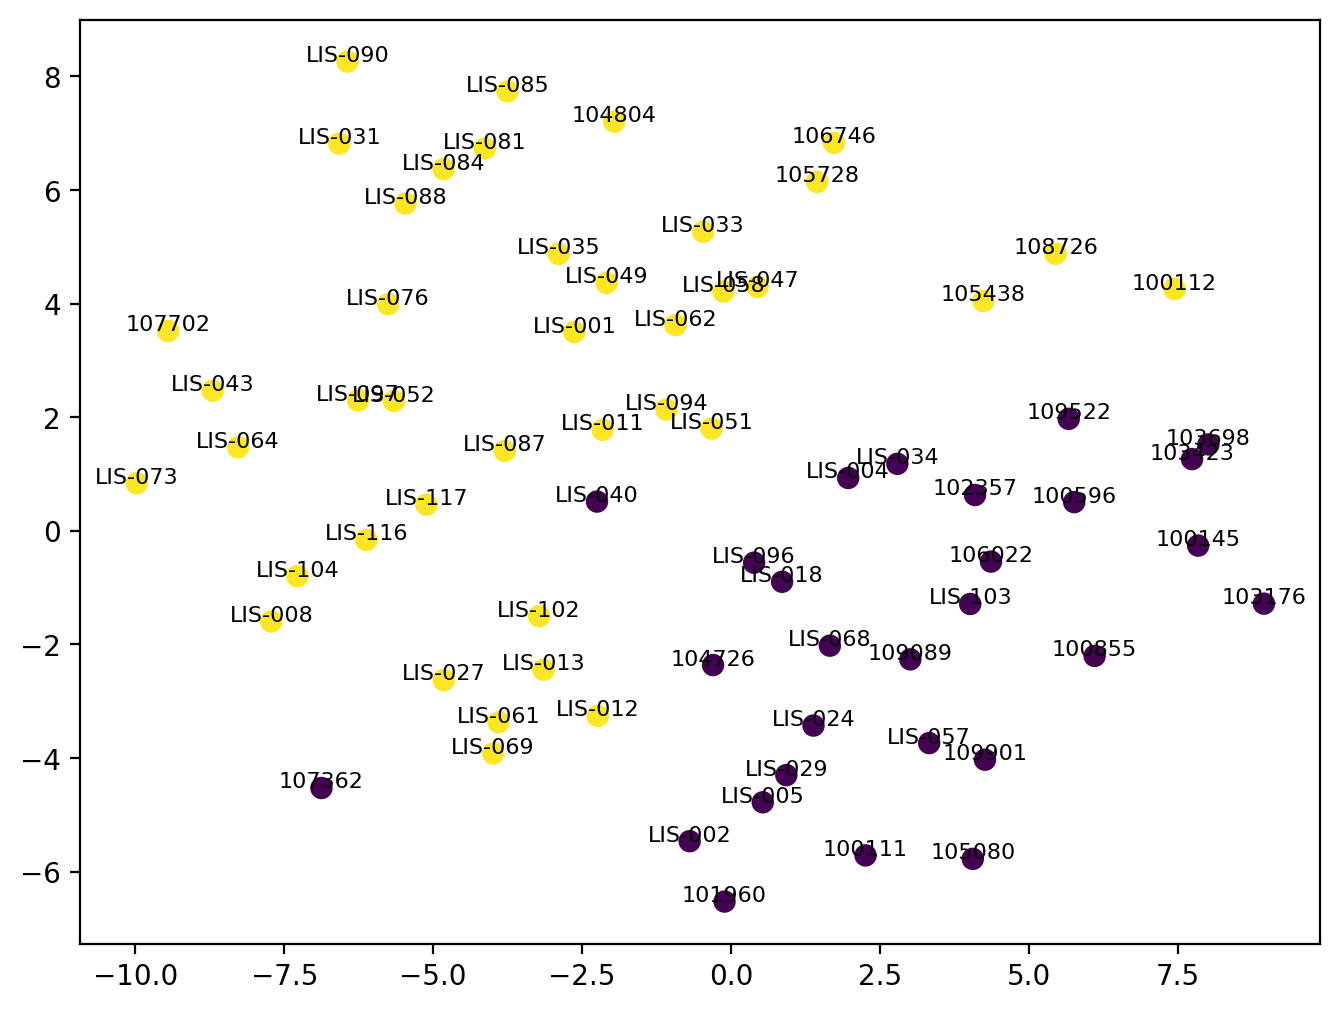

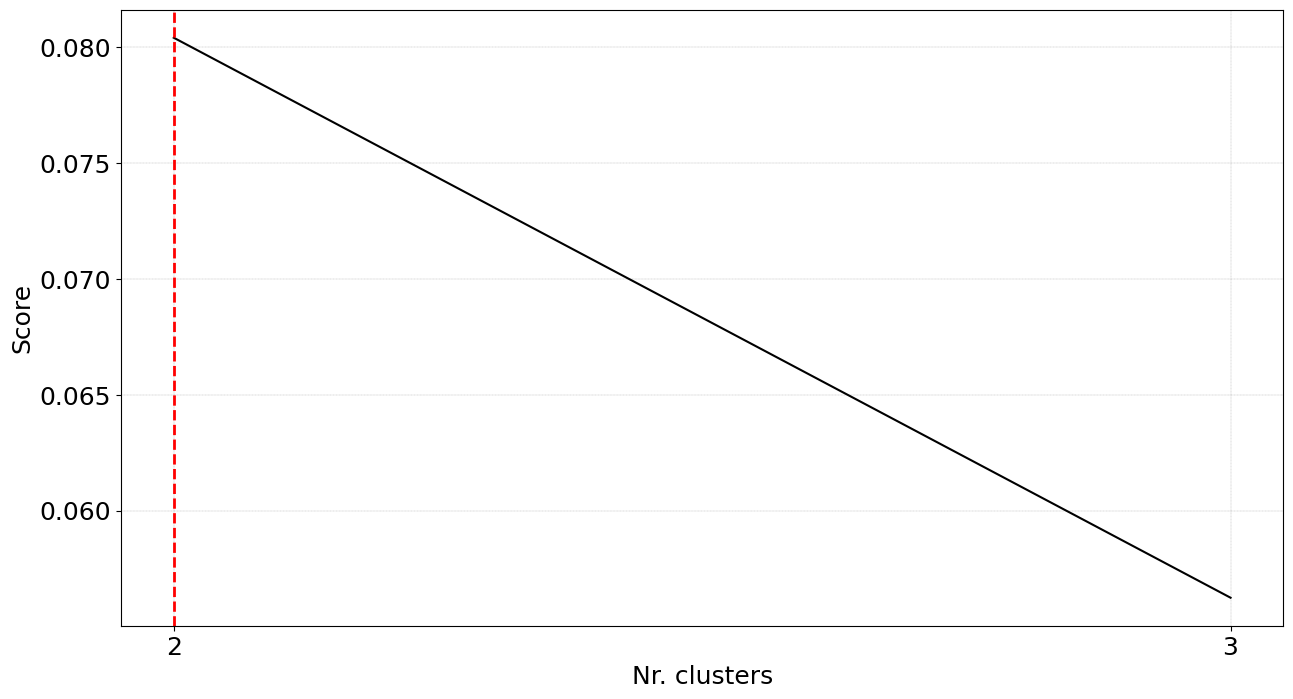

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 2, average silhouette_score=0.102


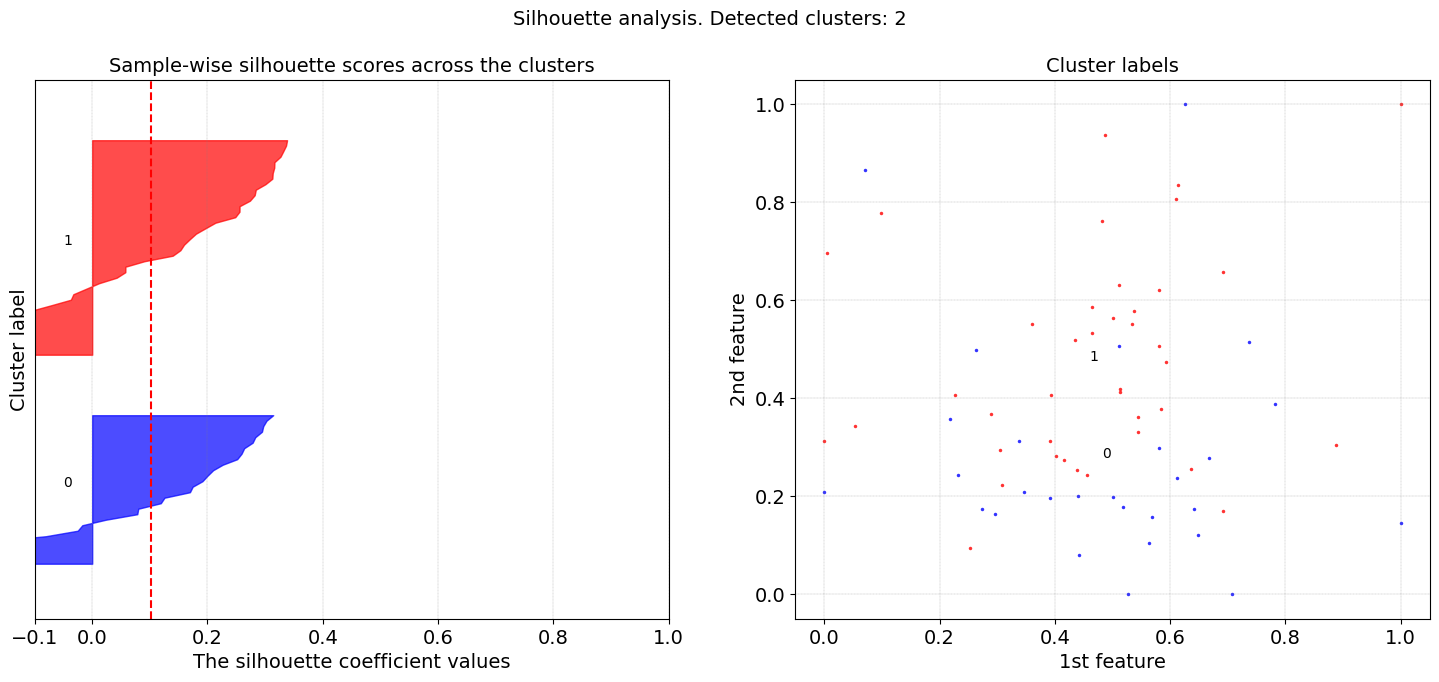

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=4.373. Be patient now..
[clusteval] >INFO> Compute cluster labels.


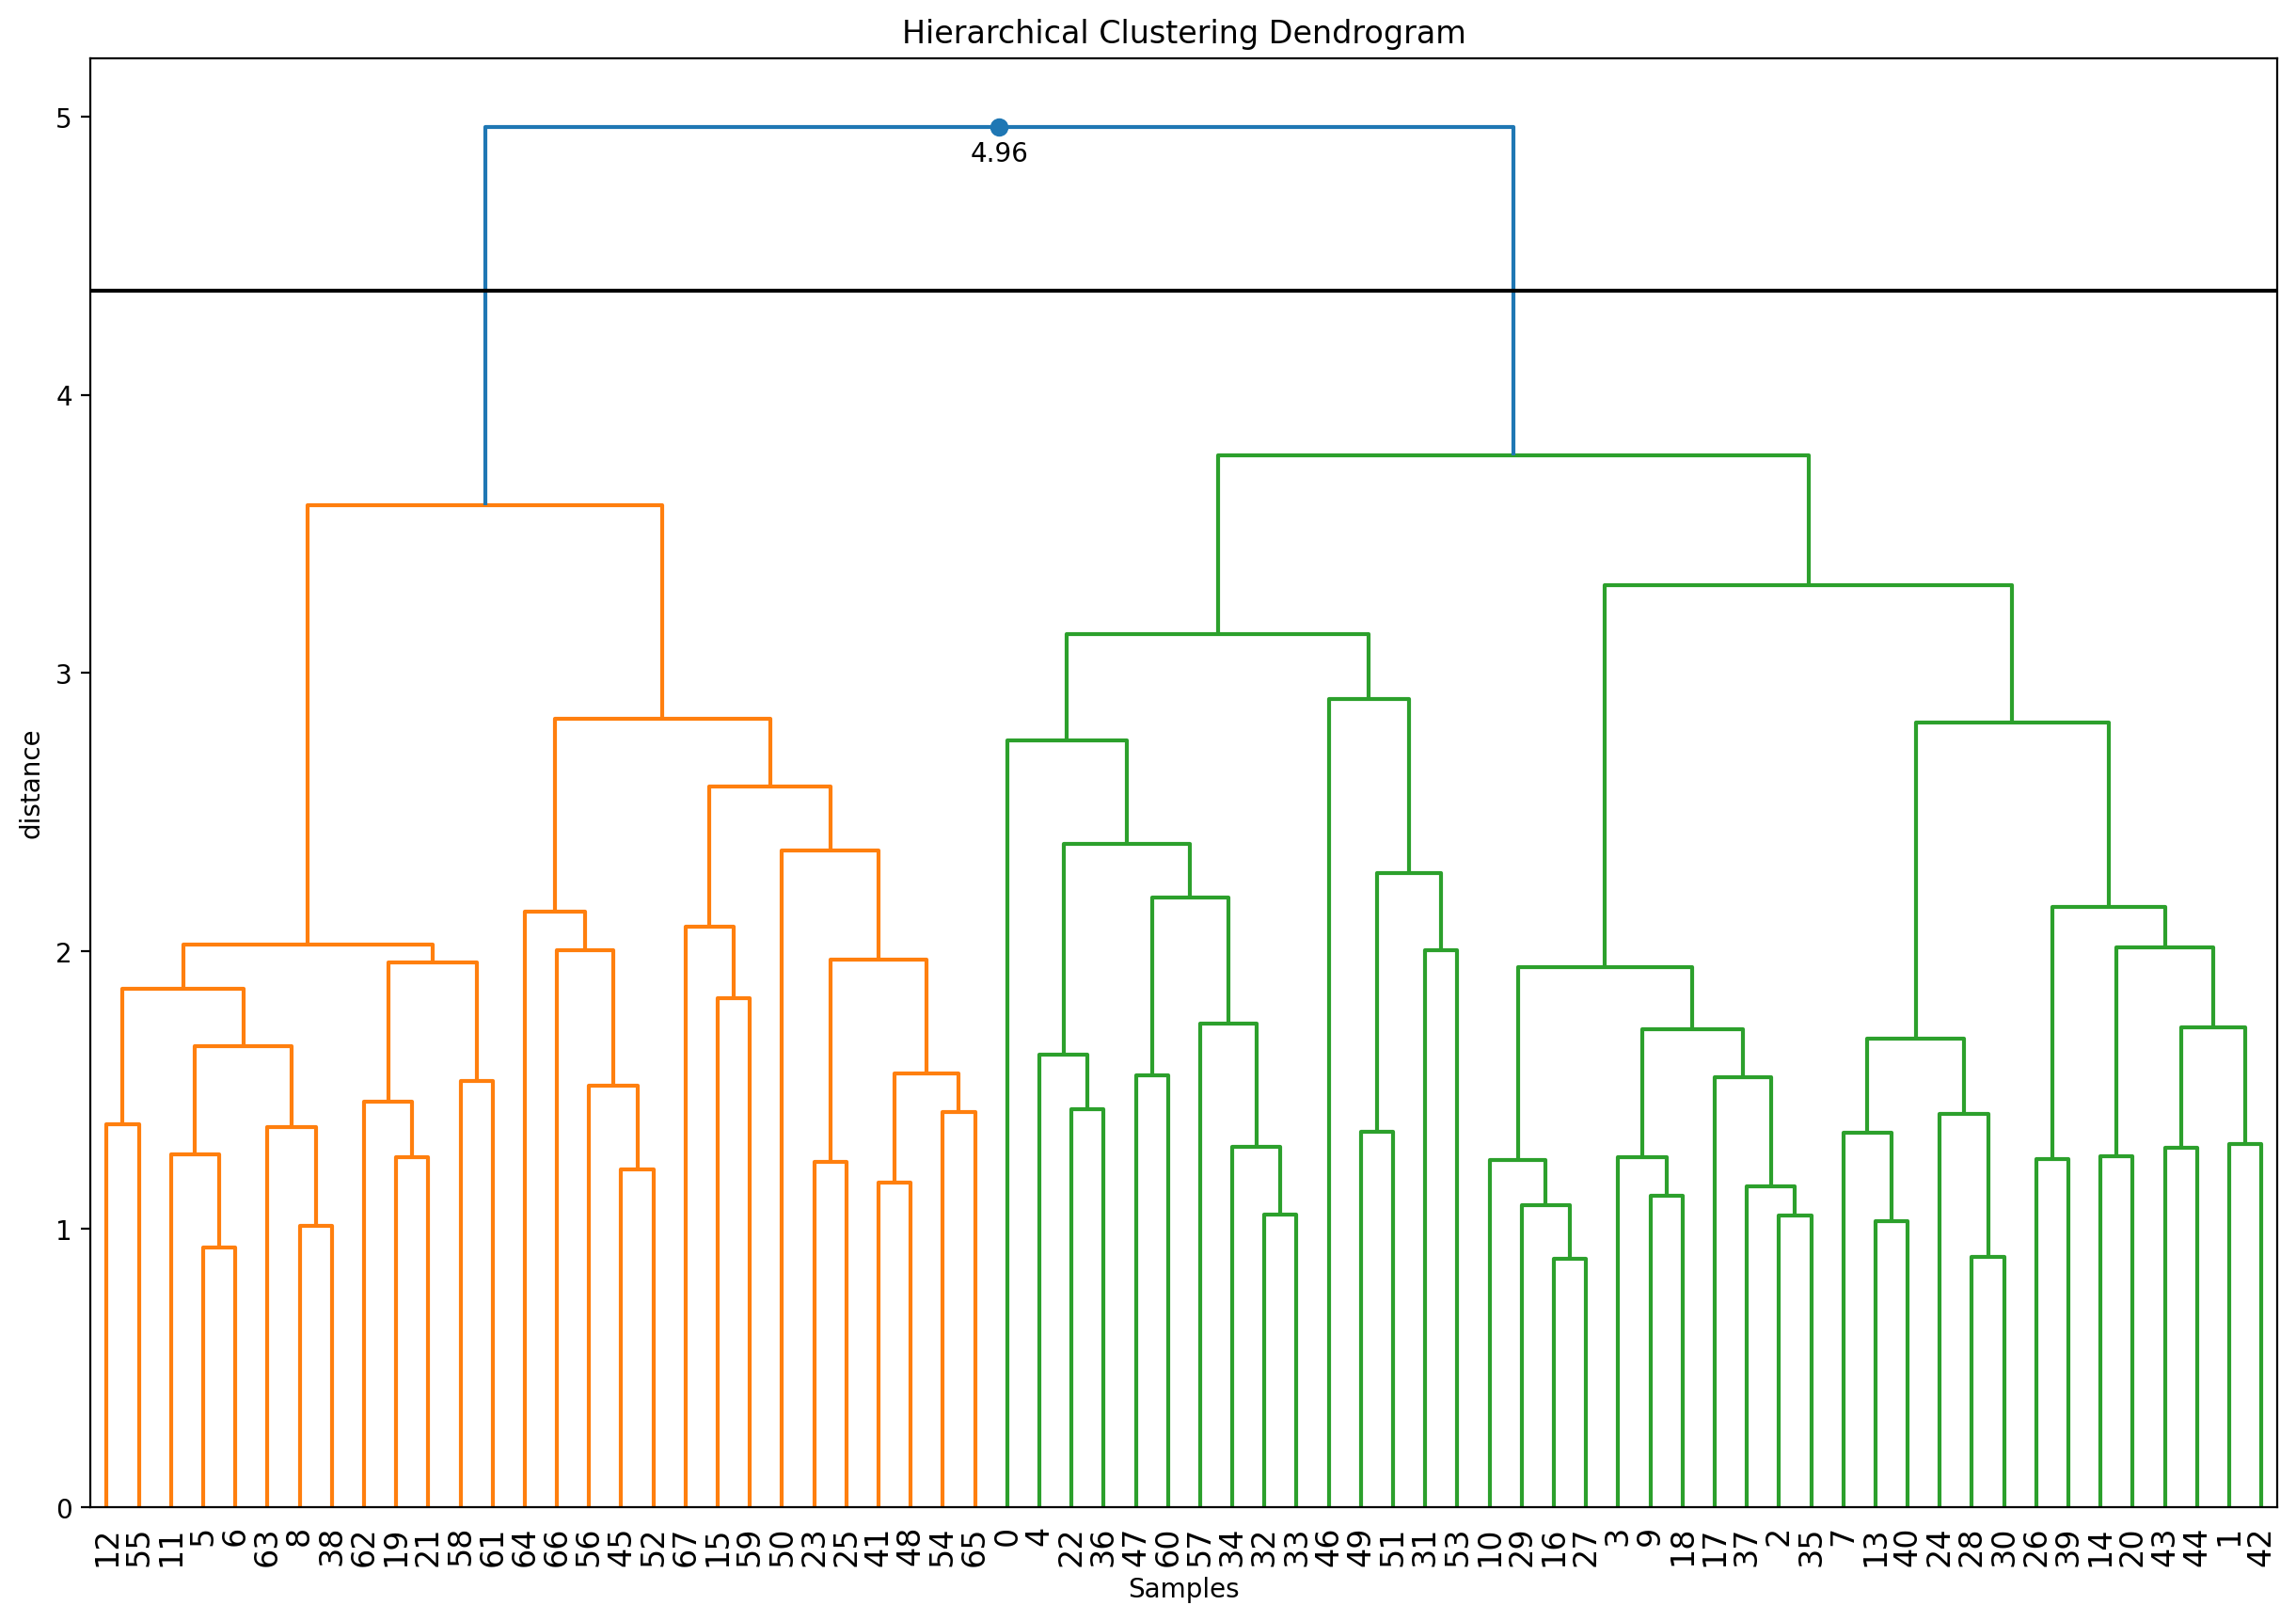

In [50]:
if dir == 'lisbon':
    features = ['NRP2', 'COMP', 'NBL1', 'FETUA', 'A1AG1', 'APOA1', 'PGS2', 'DCC', 'HRG', 'APOL1', 'FBLN2', 'ITIH4', 'LFNG', 'C1QC', 'COEA1', 'FHR2', 'HEP2', 'IBP7', 'CNTP2', 'TTHY', 'ISLR', 'APLP1', 'FRIL', 'LV657', 'NCAN', 'ALS', 'CO6', 'A2GL', 'SLIK4', 'RTN4R', 'GRIA4', 'RENR', 'HPRT', 'NPTXR', 'SPRC', 'CO3', 'CNTN1', 'ENPP2', '1433G', 'PTGDS', 'ALDOC', 'LDHA', 'GLU2B', 'MRC1', 'CD166']
elif dir == 'coimbra':
    features = ['APOH', 'HEMO', 'IBP7', 'RNAS1', 'TTHY', 'GLYLB', 'CIP4', 'KV113', 'CNTP2']
else:
    #features = ['CNTP2', 'TTHY', 'IBP7']
    features = ['FETUA', 'IBP7', 'ENPP2', 'GLYLB', 'NBL1', 'FBLN2', 'PGS2', 'CFAI', 'C1QC', 'CO3', 'AACT', 'MYO6', 'DCC', 'VASN', 'SIAE', 'SCG1', 'C1S', 'APOA4', '1433G', 'SCG3', 'APOA1', 'CD109', 'CATF', 'CNTN1', 'NID2', 'NRP2', 'FINC', 'APOH', 'COMP', 'FHR2', 'HEP2', 'MRC2']
df_clust = df[features]
df_clust = df_clust.loc[patient_group == 'MCI-AD'].values

patient_code_clust = list(patient_code.loc[patient_group == 'MCI-AD'])
lis_index = []
coim_index = []
for i, s in enumerate(patient_code_clust):
    if s.startswith('LIS'):
        lis_index.append(i)
    else:
        coim_index.append(i)

#print(df_clust.apply(lambda x: x.str.encode('ascii', 'ignore').decode('ascii') if x.dtype == "object" else x))
scaler = MinMaxScaler()
df_clust[lis_index] = scaler.fit_transform(df_clust[lis_index])
df_clust[coim_index] = scaler.fit_transform(df_clust[coim_index])
#df_clust = scaler.fit_transform(df_clust)
clustering(df_clust, patient_code_clust)

**Comparing Selected features** 

Intersection of Lis and Coim: {'IBP7', 'CNTP2', 'TTHY'}
Intersection of Lis and Lis+Coim: {'FBLN2', 'NRP2', 'FETUA', 'DCC', 'ENPP2', 'COMP', 'CO3', 'APOA1', 'IBP7', 'NBL1', 'HEP2', 'CNTN1', 'PGS2', 'C1QC', 'FHR2', '1433G'}
Intersection of Coim and Lis+Coim: {'APOH', 'IBP7', 'GLYLB'}


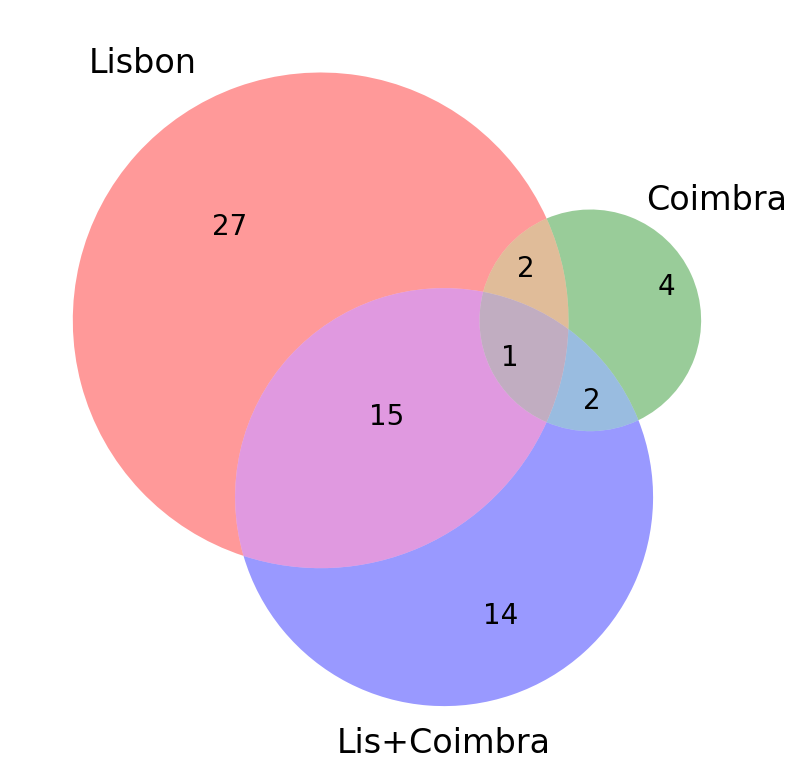

In [29]:
set1 = set(['NRP2', 'COMP', 'NBL1', 'FETUA', 'A1AG1', 'APOA1', 'PGS2', 'DCC', 'HRG', 'APOL1', 'FBLN2', 'ITIH4', 'LFNG', 'C1QC', 'COEA1', 'FHR2', 'HEP2', 'IBP7', 'CNTP2', 'TTHY', 'ISLR', 'APLP1', 'FRIL', 'LV657', 'NCAN', 'ALS', 'CO6', 'A2GL', 'SLIK4', 'RTN4R', 'GRIA4', 'RENR', 'HPRT', 'NPTXR', 'SPRC', 'CO3', 'CNTN1', 'ENPP2', '1433G', 'PTGDS', 'ALDOC', 'LDHA', 'GLU2B', 'MRC1', 'CD166'])
set2 = set(['APOH', 'HEMO', 'IBP7', 'RNAS1', 'TTHY', 'GLYLB', 'CIP4', 'KV113', 'CNTP2'])
set3 = set(['FETUA', 'IBP7', 'ENPP2', 'GLYLB', 'NBL1', 'FBLN2', 'PGS2', 'CFAI', 'C1QC', 'CO3', 'AACT', 'MYO6', 'DCC', 'VASN', 'SIAE', 'SCG1', 'C1S', 'APOA4', '1433G', 'SCG3', 'APOA1', 'CD109', 'CATF', 'CNTN1', 'NID2', 'NRP2', 'FINC', 'APOH', 'COMP', 'FHR2', 'HEP2', 'MRC2'])
venn3([set1, set2, set3], ('Lisbon', 'Coimbra', 'Lis+Coimbra'))
# Calculate intersections
intersection_12 = set1 & set2
intersection_13 = set1 & set3
intersection_23 = set2 & set3
intersection_123 = set1 & set2 & set3
# Print intersection results
print("Intersection of Lis and Coim:", intersection_12)
print("Intersection of Lis and Lis+Coim:", intersection_13)
print("Intersection of Coim and Lis+Coim:", intersection_23)


**Comparing Patients** 

In [57]:
lisbon = pd.read_csv('../data/lisbon/results/clusters_results.csv')
l0 = set(lisbon.loc[lisbon['Cluster'] == 0]['Code'])
l1 = set(lisbon.loc[lisbon['Cluster'] == 1]['Code'])
coimbra = pd.read_csv('../data/coimbra/results/clusters_results.csv')
c0 = set(coimbra.loc[coimbra['Cluster'] == 0]['Code'].astype(str))
c1 = set(coimbra.loc[coimbra['Cluster'] == 1]['Code'].astype(str))
lis_coim = pd.read_csv('../data/lisbon+coimbra/results/clusters_results_each_norm_intersect.csv')
cl0 = set(lis_coim.loc[lis_coim['Cluster'] == 0]['Code'])
cl1 = set(lis_coim.loc[lis_coim['Cluster'] == 1]['Code'])
cl2 = set(lis_coim.loc[lis_coim['Cluster'] == 2]['Code'])

#dict of sets
sets = {
    'L0': l0,
    'L1': l1,
    'CL0': cl0,
    'CL1': cl1,
    'CL2': cl2}

# Plot Venn diagram for l1, l0, and cl1, cl0, c1, c0 sets
venn(sets)  


#dict of sets
sets = {
    'C0': c0,
    'C1': c1,
    'CL0': cl0,
    'CL1': cl1,
    'CL2': cl2}

# Plot Venn diagram for l1, l0, and cl1, cl0, c1, c0 sets
venn(sets)  
# Calculate intersections
#intersection_13 = (l0 | l1) & (cl0 | cl1)  # Lisbon & Lisbon+Coimbra
#intersection_23 = (c0 | c1) & (cl0 | cl1)  # Coimbra & Lisbon+Coimbra

# Print intersection results
#print("Intersection of Lis and Lis+Coim:", intersection_13)
#print("Intersection of Coim and Lis+Coim:", intersection_23)


NameError: name 'venny5py' is not defined